In [1]:
!pip install seaborn pandas scipy scikit-learn dask[complete]
!python3 -m pip install --upgrade pip

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
import seaborn as sns
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

2024-02-20 22:23:55.220894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 22:23:55.220927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 22:23:55.221779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 22:23:55.226867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_dir = pathlib.Path('data2').with_suffix('')

In [4]:
data = 'data2'

paths = [path.parts[-2:] for path in
         pathlib.Path(data).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df                                                            #display dataframe

,Class,Images
0,Cellulitis,Cellulities47.jpg
1,Cellulitis,Cellulities49.jpg
2,Cellulitis,Cellulities40.jpg
3,Cellulitis,Cellulities12.jpg
4,Cellulitis,Cellulities32.jpg
...,...,...
895,Vitiligo,vitiligo46.jpg
896,Vitiligo,vitiligo44.jpg
897,Vitiligo,vitiligo2.jpg
898,Vitiligo,vitiligo49.jpg


In [5]:
print('Count the number of image datasets')
print("Image Count : {}".format(len(df.Images)))
print("Class Count : {} \n".format(len(df['Class'].value_counts())))
print('Count the number of images in each class')
print(df['Class'].value_counts())

Count the number of image datasets
Image Count : 900
Class Count : 10 

Count the number of images in each class
Class
Cellulitis    100
Chickenpox    100
Dermatitis    100
Eczema        100
Hives         100
Lupus         100
Psoriasis     100
Ringworm      100
Melanoma       50
Vitiligo       50
Name: count, dtype: int64


Text(0, 0.5, 'Count Image')

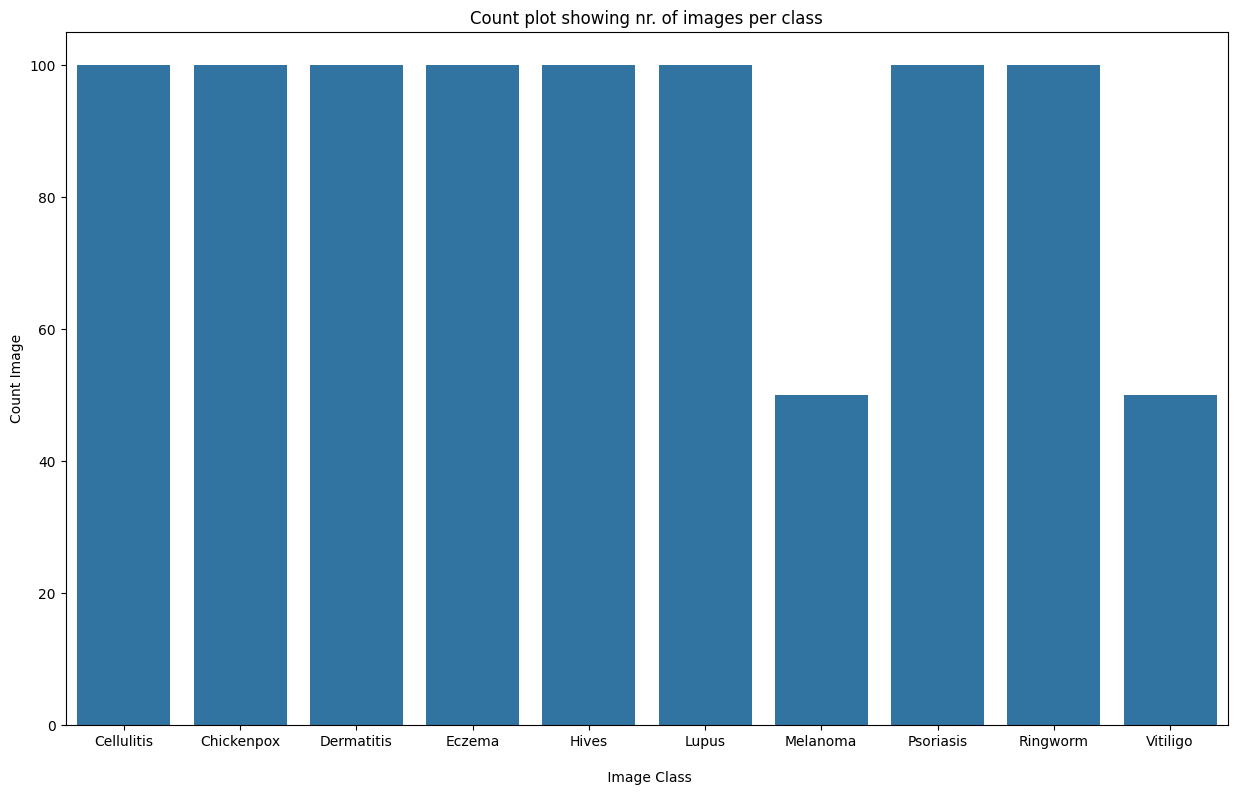

In [6]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Count plot showing nr. of images per class')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

We have a good distribution of images, no over- or underepresentation of any of the classes.

In [7]:
image_count = len(list(data_dir.glob('*/*.jpeg')))+len(list(data_dir.glob('*/*.jpg')))+len(list(data_dir.glob('*/*.png'))) # folder/name <- */*
print(image_count)

900


In [8]:
directories = {'Cellulitis': 'data2/Cellulitis/',
               'Chickenpox': 'data2/Chickenpox/',
               'Dermatitis': 'data2/Dermatitis/',
               'Eczema': 'data2/Eczema/',
               'Hives': 'data2/Hives/',
               'Lupus': 'data2/Lupus/',
               'Melanoma': 'data2/Melanoma/',
               'Psoriasis': 'data2/Psoriasis/',
               'Ringworm': 'data2/Ringworm/',
               'Vitiligo': 'data2/Vitiligo/'
              }

def get_dims(file):
  im = Image.open(file)
  
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

def get_rgb(file):
    im = Image.open(file)
    arr = np.array(im)
    r_mean = np.mean(arr[:,:,0])
    g_mean = np.mean(arr[:,:,1])
    b_mean = np.mean(arr[:,:,2])
    bright_mean = np.mean([r_mean, g_mean, b_mean])
    return r_mean, g_mean, b_mean, bright_mean

[########################################] | 100% Completed | 717.54 ms
[########################################] | 100% Completed | 710.62 ms
[########################################] | 100% Completed | 709.66 ms
[########################################] | 100% Completed | 723.93 ms
[########################################] | 100% Completed | 712.76 ms
[########################################] | 100% Completed | 713.67 ms
[########################################] | 100% Completed | 609.51 ms
[########################################] | 100% Completed | 723.80 ms
[########################################] | 100% Completed | 724.08 ms
[########################################] | 100% Completed | 607.77 ms


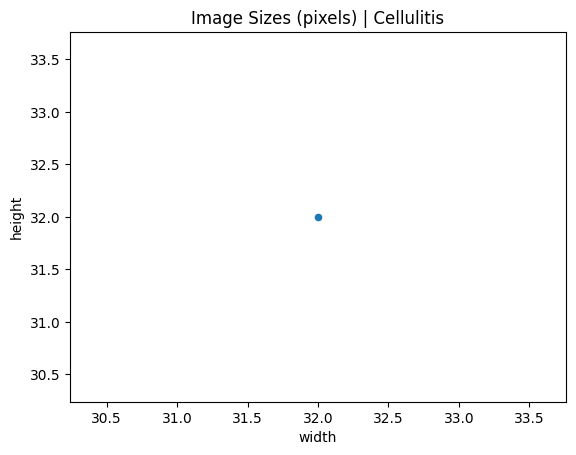

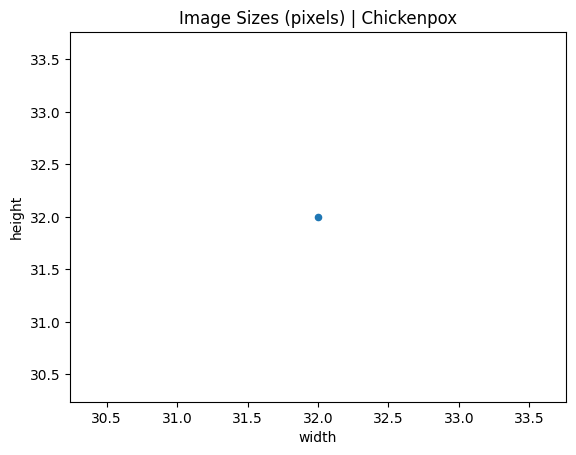

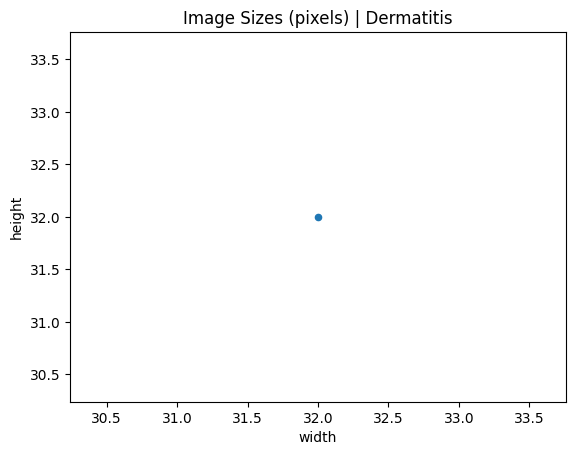

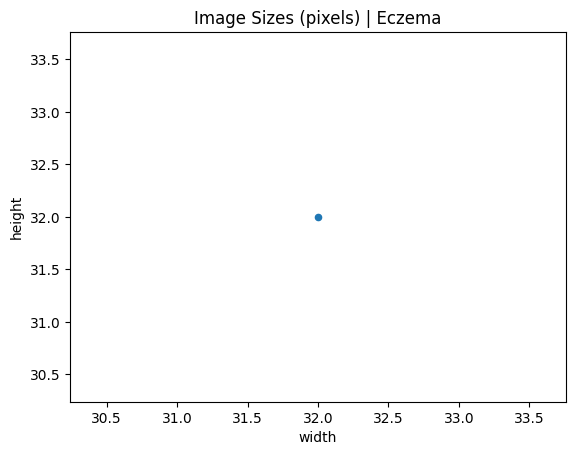

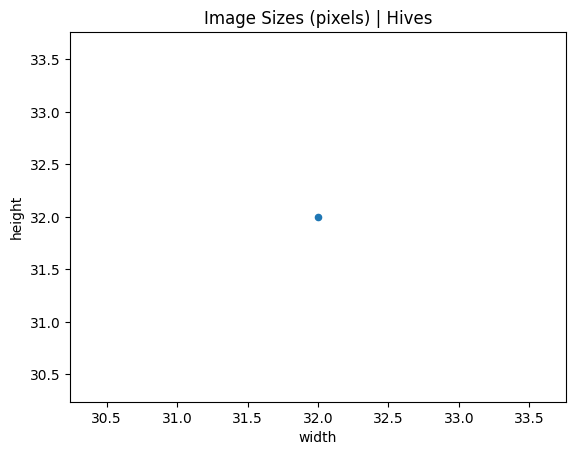

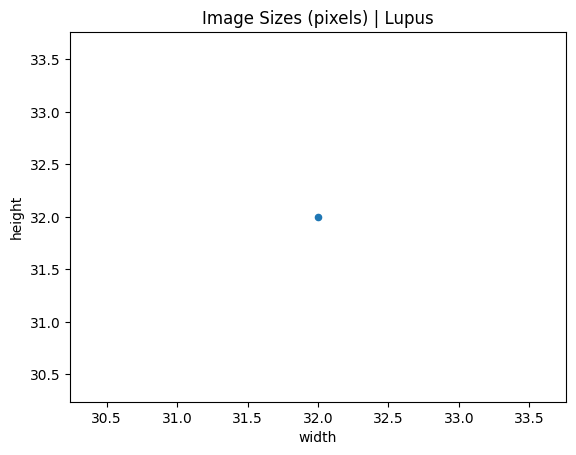

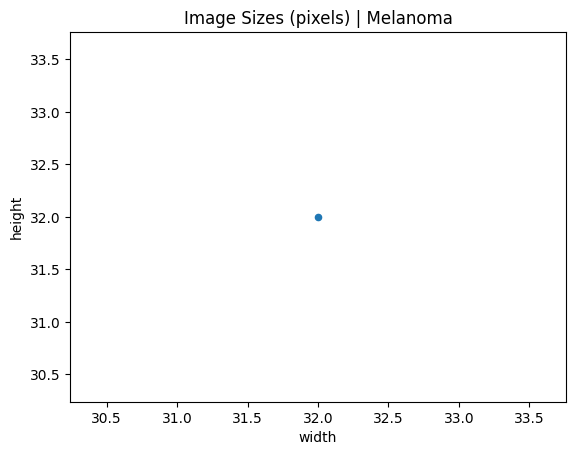

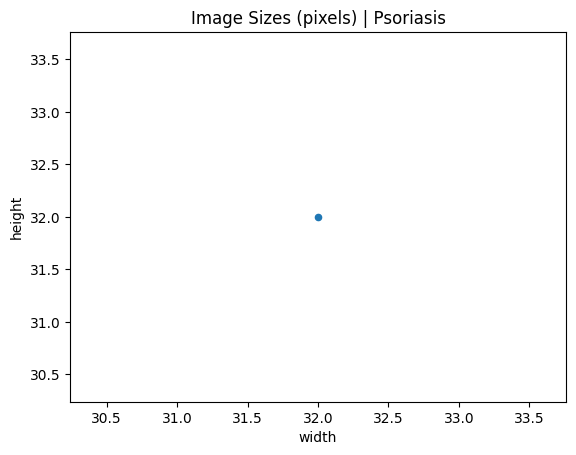

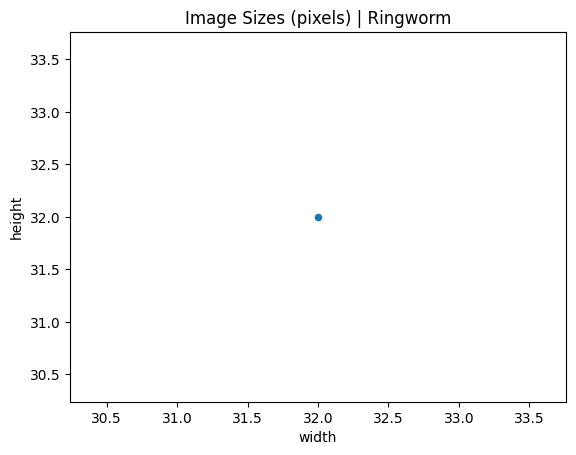

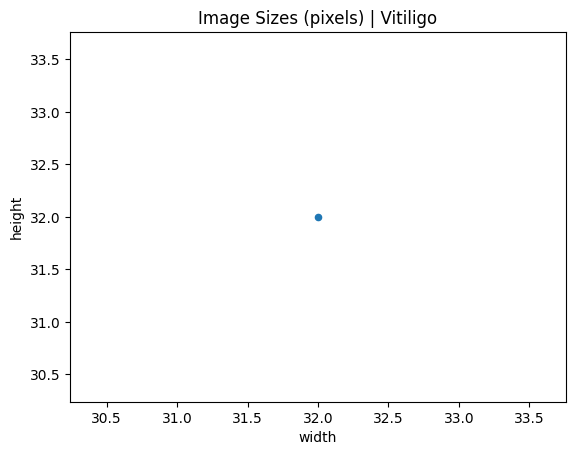

In [9]:
import os
import dask.bag as db
import dask.array as da
from dask.diagnostics import ProgressBar
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = db.from_sequence(filelist).map(get_dims)
    
  with ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

<Axes: xlabel='Brightness', ylabel='Count'>

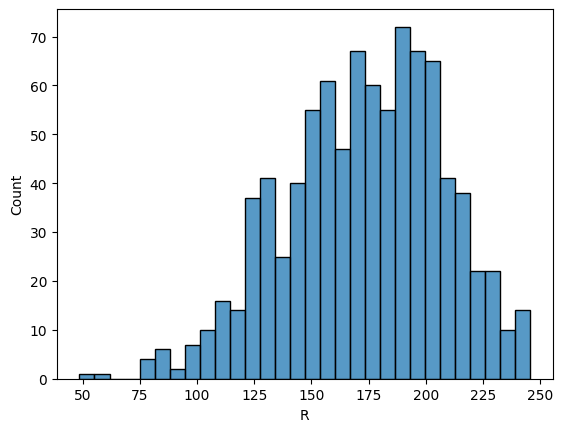

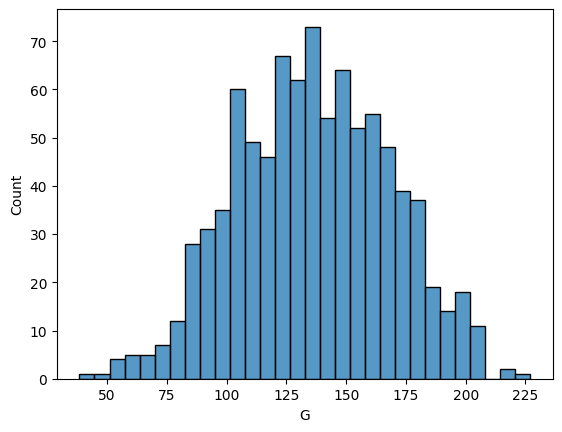

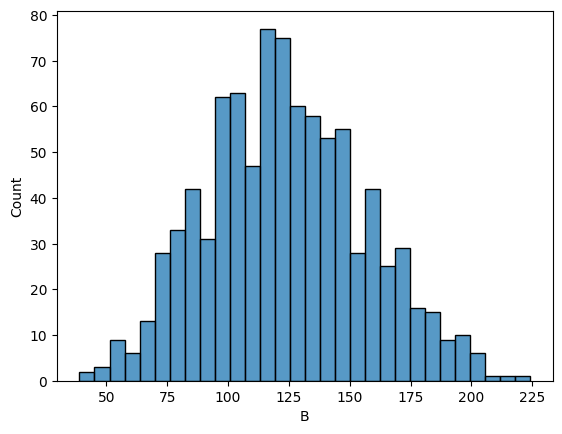

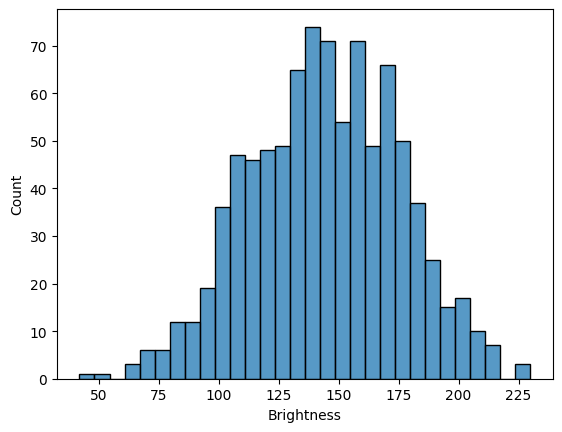

In [10]:
filelist=[]
for n,d in directories.items():
  filepath = d
  filelist+=[filepath + f for f in os.listdir(filepath)]

r_array=[]
g_array=[]
b_array=[]
bright_array=[]
for file in filelist:
    rm, gm, bm, brm = get_rgb(file)
    r_array.append(rm)
    g_array.append(gm)
    b_array.append(bm)
    bright_array.append(brm)


rgbb_df=pd.DataFrame({ 'R':r_array,
                       'G':g_array,
                       'B':b_array,
                       'Brightness':bright_array})
fig1 = plt.figure()
sns.histplot(data=rgbb_df, x = 'R',  bins=30)
fig2 = plt.figure()
sns.histplot(data=rgbb_df, x = 'G',  bins=30)
fig3=plt.figure()
sns.histplot(data=rgbb_df, x = 'B',  bins=30)
fig4=plt.figure()
sns.histplot(data=rgbb_df, x = 'Brightness',  bins=30)


In [11]:
rgbb_df.describe()

,R,G,B,Brightness
count,900.000000,900.000000,900.000000,900.000000
mean,172.824150,136.323636,123.590013,144.245933
std,34.594986,32.256697,32.576855,31.288120
min,48.543945,38.411133,38.991211,41.982096
25%,149.871338,112.060547,100.146729,122.205078
50%,175.088867,135.539062,121.616699,144.108724
75%,198.125000,160.634766,144.970703,168.015137
max,245.762695,227.058594,224.174805,229.902344


In [12]:
rgbb_df.skew()

R            -0.333606
G            -0.022972
B             0.182379
Brightness   -0.087542
dtype: float64

In [13]:
rgbb_df.kurtosis()

R            -0.200377
G            -0.397464
B            -0.329149
Brightness   -0.295304
dtype: float64

In [14]:
#We have to resize the images, not all of them are at 128 x 128 - rerun this file afterwards
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  for file in filelist:
      im = Image.open(file)
      im = im.resize((32,32))
      im = im.convert('RGB')
      
      im.save(file)

Let's begin looking at some deep learning models.

In [15]:
batch_size = 16
img_height = 32
img_width = 32

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 10 classes.
Using 810 files for training.


2024-02-20 22:24:08.162067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 22:24:08.166607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 22:24:08.166809: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(  #the tf terminology for this method demands the term validation where we we might otherwise use the term test. Just know that validation in this case means test, we're not doing a 3-way split of the data nor k-fold cross-validation
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 10 classes.
Using 90 files for validation.


Let's see if we have all the classes represented in both the training and the test set.

In [18]:
#Scaling the data - part of EDA
normalization_layer = layers.Rescaling(1./255)

In [19]:
#begin with a custom Keras model, as per the tutorial on the tensorflow website pertaining to image classification:
num_classes = 10

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-02-20 22:24:09.757527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:09.758301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:09.789330: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-02-20 22:24:10.331684: I external/local_xla/xla/service/service.cc:168] XLA service 0xbcef200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 22:24:10.331702: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-20 22:24:10.336134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708467850.398157  315287 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at m

51/51 [==============================] - 4s 32ms/step - loss: 2.2803 - accuracy: 0.1333 - val_loss: 2.2502 - val_accuracy: 0.1000
Epoch 2/50
42/51 [=======================>......] - ETA: 0s - loss: 2.1843 - accuracy: 0.1667

2024-02-20 22:24:13.670060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:13.670913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 2.1776 - accuracy: 0.1790 - val_loss: 2.1511 - val_accuracy: 0.2333
Epoch 3/50
42/51 [=======================>......] - ETA: 0s - loss: 2.0823 - accuracy: 0.2351

2024-02-20 22:24:13.893964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:13.894727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 2.0683 - accuracy: 0.2395 - val_loss: 2.0986 - val_accuracy: 0.1778
Epoch 4/50
40/51 [======================>.......] - ETA: 0s - loss: 1.9616 - accuracy: 0.2688

2024-02-20 22:24:14.122764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:14.123697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.9541 - accuracy: 0.2765 - val_loss: 2.1098 - val_accuracy: 0.2556
Epoch 5/50
43/51 [========================>.....] - ETA: 0s - loss: 1.8162 - accuracy: 0.3416

2024-02-20 22:24:14.357366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:14.358089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.8102 - accuracy: 0.3519 - val_loss: 2.0250 - val_accuracy: 0.2667
Epoch 6/50
42/51 [=======================>......] - ETA: 0s - loss: 1.7165 - accuracy: 0.3973

2024-02-20 22:24:14.581542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:14.582434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.7267 - accuracy: 0.3926 - val_loss: 2.0414 - val_accuracy: 0.2889
Epoch 7/50
43/51 [========================>.....] - ETA: 0s - loss: 1.6061 - accuracy: 0.4346

2024-02-20 22:24:14.807429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:14.808180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.6008 - accuracy: 0.4420 - val_loss: 2.0544 - val_accuracy: 0.3333
Epoch 8/50
40/51 [======================>.......] - ETA: 0s - loss: 1.5187 - accuracy: 0.4563

2024-02-20 22:24:15.028505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:15.029373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.4940 - accuracy: 0.4827 - val_loss: 2.0305 - val_accuracy: 0.3333
Epoch 9/50
42/51 [=======================>......] - ETA: 0s - loss: 1.3917 - accuracy: 0.5357

2024-02-20 22:24:15.277745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:15.278575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.3890 - accuracy: 0.5259 - val_loss: 2.0346 - val_accuracy: 0.4000
Epoch 10/50
41/51 [=======================>......] - ETA: 0s - loss: 1.3177 - accuracy: 0.5488

2024-02-20 22:24:15.511325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:15.512291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.3015 - accuracy: 0.5654 - val_loss: 2.0793 - val_accuracy: 0.3444
Epoch 11/50
41/51 [=======================>......] - ETA: 0s - loss: 1.2682 - accuracy: 0.5640

2024-02-20 22:24:15.748451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:15.749165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.2711 - accuracy: 0.5642 - val_loss: 2.0620 - val_accuracy: 0.3556
Epoch 12/50
41/51 [=======================>......] - ETA: 0s - loss: 1.0565 - accuracy: 0.6509

2024-02-20 22:24:15.981195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:15.981881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 1.0539 - accuracy: 0.6543 - val_loss: 2.1265 - val_accuracy: 0.3667
Epoch 13/50
37/51 [====================>.........] - ETA: 0s - loss: 0.9888 - accuracy: 0.6639

2024-02-20 22:24:16.221895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:16.222729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.9612 - accuracy: 0.6704 - val_loss: 2.2805 - val_accuracy: 0.3333
Epoch 14/50
39/51 [=====================>........] - ETA: 0s - loss: 0.8327 - accuracy: 0.7179

2024-02-20 22:24:16.485067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:16.485673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.8077 - accuracy: 0.7333 - val_loss: 2.4441 - val_accuracy: 0.3000
Epoch 15/50
39/51 [=====================>........] - ETA: 0s - loss: 0.8539 - accuracy: 0.7212

2024-02-20 22:24:16.728214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:16.729057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.8363 - accuracy: 0.7284 - val_loss: 2.3018 - val_accuracy: 0.4000
Epoch 16/50
37/51 [====================>.........] - ETA: 0s - loss: 0.7127 - accuracy: 0.7736

2024-02-20 22:24:16.983450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:16.984088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.7081 - accuracy: 0.7778 - val_loss: 2.3133 - val_accuracy: 0.3778
Epoch 17/50
40/51 [======================>.......] - ETA: 0s - loss: 0.5814 - accuracy: 0.8250

2024-02-20 22:24:17.236217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:17.236807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.5729 - accuracy: 0.8198 - val_loss: 2.8166 - val_accuracy: 0.3889
Epoch 18/50
37/51 [====================>.........] - ETA: 0s - loss: 0.5504 - accuracy: 0.8260

2024-02-20 22:24:17.480273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:17.481106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.5227 - accuracy: 0.8358 - val_loss: 2.6842 - val_accuracy: 0.4222
Epoch 19/50
39/51 [=====================>........] - ETA: 0s - loss: 0.4021 - accuracy: 0.8814

2024-02-20 22:24:17.736933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:17.737786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.3990 - accuracy: 0.8765 - val_loss: 2.9788 - val_accuracy: 0.4111
Epoch 20/50
38/51 [=====================>........] - ETA: 0s - loss: 0.4077 - accuracy: 0.8717

2024-02-20 22:24:17.988017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:17.988906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.4016 - accuracy: 0.8728 - val_loss: 2.9530 - val_accuracy: 0.4111
Epoch 21/50
43/51 [========================>.....] - ETA: 0s - loss: 0.3151 - accuracy: 0.9099

2024-02-20 22:24:18.232554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:18.233161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.3221 - accuracy: 0.9086 - val_loss: 3.4778 - val_accuracy: 0.3556
Epoch 22/50
42/51 [=======================>......] - ETA: 0s - loss: 0.3316 - accuracy: 0.8973

2024-02-20 22:24:18.453409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:18.454009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.3066 - accuracy: 0.9086 - val_loss: 3.3918 - val_accuracy: 0.4111
Epoch 23/50
38/51 [=====================>........] - ETA: 0s - loss: 0.2660 - accuracy: 0.9211

2024-02-20 22:24:18.685884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:18.686660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.2660 - accuracy: 0.9198 - val_loss: 3.4944 - val_accuracy: 0.4111
Epoch 24/50
40/51 [======================>.......] - ETA: 0s - loss: 0.2262 - accuracy: 0.9312

2024-02-20 22:24:18.926031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:18.926671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.2237 - accuracy: 0.9333 - val_loss: 3.5257 - val_accuracy: 0.4444
Epoch 25/50
40/51 [======================>.......] - ETA: 0s - loss: 0.1653 - accuracy: 0.9563

2024-02-20 22:24:19.160404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:19.161260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.1574 - accuracy: 0.9593 - val_loss: 3.7390 - val_accuracy: 0.4111
Epoch 26/50
43/51 [========================>.....] - ETA: 0s - loss: 0.1701 - accuracy: 0.9608

2024-02-20 22:24:19.393484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:19.394088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.1625 - accuracy: 0.9617 - val_loss: 3.8430 - val_accuracy: 0.4111
Epoch 27/50
43/51 [========================>.....] - ETA: 0s - loss: 0.1320 - accuracy: 0.9564

2024-02-20 22:24:19.609334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:19.609924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.1331 - accuracy: 0.9568 - val_loss: 3.9461 - val_accuracy: 0.4111
Epoch 28/50
43/51 [========================>.....] - ETA: 0s - loss: 0.1472 - accuracy: 0.9549

2024-02-20 22:24:19.823801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:19.824392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.1404 - accuracy: 0.9593 - val_loss: 3.8702 - val_accuracy: 0.4111
Epoch 29/50
43/51 [========================>.....] - ETA: 0s - loss: 0.1239 - accuracy: 0.9637

2024-02-20 22:24:20.038283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:20.038877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.1219 - accuracy: 0.9630 - val_loss: 4.2928 - val_accuracy: 0.4333
Epoch 30/50
38/51 [=====================>........] - ETA: 0s - loss: 0.0978 - accuracy: 0.9704

2024-02-20 22:24:20.258211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:20.258894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.0945 - accuracy: 0.9741 - val_loss: 4.3121 - val_accuracy: 0.4222
Epoch 31/50
36/51 [====================>.........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9757

2024-02-20 22:24:20.513123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:20.513958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.0732 - accuracy: 0.9753 - val_loss: 4.3935 - val_accuracy: 0.4333
Epoch 32/50
39/51 [=====================>........] - ETA: 0s - loss: 0.0544 - accuracy: 0.9888

2024-02-20 22:24:20.779360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:20.780351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.0486 - accuracy: 0.9901 - val_loss: 4.4670 - val_accuracy: 0.4556
Epoch 33/50
38/51 [=====================>........] - ETA: 0s - loss: 0.0503 - accuracy: 0.9868

2024-02-20 22:24:21.027964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:21.028737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.0483 - accuracy: 0.9889 - val_loss: 4.7044 - val_accuracy: 0.4333
Epoch 34/50
38/51 [=====================>........] - ETA: 0s - loss: 0.0379 - accuracy: 0.9951

2024-02-20 22:24:21.278887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:21.279530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.0355 - accuracy: 0.9963 - val_loss: 4.7610 - val_accuracy: 0.4444
Epoch 35/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0194 - accuracy: 0.9985

2024-02-20 22:24:21.517957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:21.518522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0190 - accuracy: 0.9988 - val_loss: 5.1213 - val_accuracy: 0.4222
Epoch 36/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0255 - accuracy: 0.9956

2024-02-20 22:24:21.734535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:21.735081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0232 - accuracy: 0.9963 - val_loss: 4.8644 - val_accuracy: 0.4222
Epoch 37/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0181 - accuracy: 0.9971

2024-02-20 22:24:21.949809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:21.950397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0166 - accuracy: 0.9975 - val_loss: 4.9830 - val_accuracy: 0.4222
Epoch 38/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0194 - accuracy: 0.9971

2024-02-20 22:24:22.166529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:22.167190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0188 - accuracy: 0.9975 - val_loss: 5.0262 - val_accuracy: 0.4444
Epoch 39/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0171 - accuracy: 0.9985

2024-02-20 22:24:22.383951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:22.384510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0164 - accuracy: 0.9988 - val_loss: 5.4469 - val_accuracy: 0.4444
Epoch 40/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

2024-02-20 22:24:22.600156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:22.600779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 5.3543 - val_accuracy: 0.4333
Epoch 41/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

2024-02-20 22:24:22.817363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:22.817952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 5.4551 - val_accuracy: 0.4444
Epoch 42/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

2024-02-20 22:24:23.036297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:23.036835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 5.4818 - val_accuracy: 0.4444
Epoch 43/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

2024-02-20 22:24:23.252444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:23.253083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 5.5956 - val_accuracy: 0.4444
Epoch 44/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

2024-02-20 22:24:23.468798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:23.469408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 5.6326 - val_accuracy: 0.4444
Epoch 45/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

2024-02-20 22:24:23.683998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:23.684576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.6994 - val_accuracy: 0.4444
Epoch 46/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

2024-02-20 22:24:23.900666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:23.901243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 5.7198 - val_accuracy: 0.4444
Epoch 47/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

2024-02-20 22:24:24.116175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:24.116736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 5.7729 - val_accuracy: 0.4444
Epoch 48/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

2024-02-20 22:24:24.333190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:24.333777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.8234 - val_accuracy: 0.4556
Epoch 49/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

2024-02-20 22:24:24.549463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:24.549960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.8782 - val_accuracy: 0.4556
Epoch 50/50
43/51 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

2024-02-20 22:24:24.765995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:24.766559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 5.8908 - val_accuracy: 0.4556


In [22]:
#hist = model.fit_generator(steps_per_epoch=10,generator=train_ds, validation_data= val_ds,epochs=20)

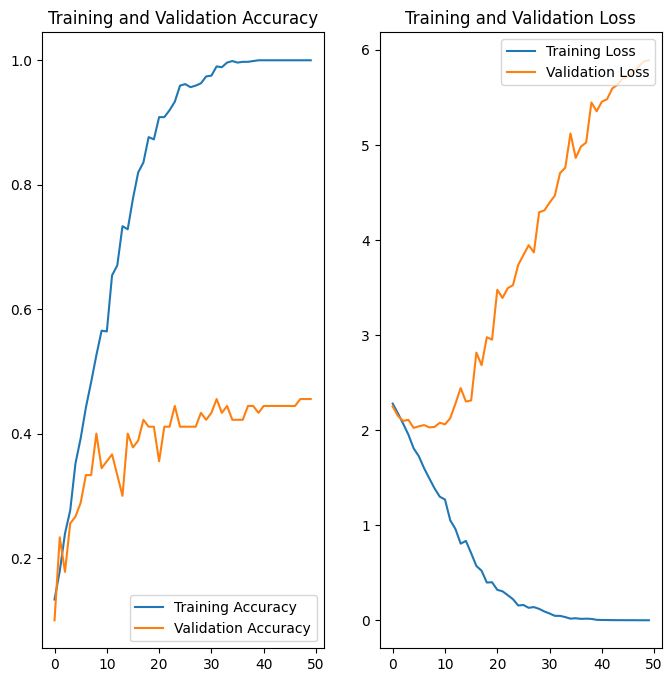

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's see how we can tune this model for better performance. We will first introduce an augmentation layer, then introduce dropout layers as well and lower the learning rate.

In [24]:
img_height = 32
img_width = 32
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    #layers.RandomZoom(0.1),
  ]
)

In [25]:
#plt.figure(figsize=(10, 10))
#for images, _ in train_ds.take(1):
#  for i in range(9):
#    augmented_images = data_augmentation(images)
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(augmented_images[0].numpy().astype("uint8"))
#    plt.axis("off")

In [26]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [27]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs = 50
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-02-20 22:24:25.853709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-20 22:24:25.917960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:25.918511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 4s 26ms/step - loss: 2.2843 - accuracy: 0.1420 - val_loss: 2.2694 - val_accuracy: 0.1000
Epoch 2/50
34/51 [===================>..........] - ETA: 0s - loss: 2.2497 - accuracy: 0.1268

2024-02-20 22:24:29.221403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:29.221957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 2.2280 - accuracy: 0.1407 - val_loss: 2.2313 - val_accuracy: 0.1000
Epoch 3/50
34/51 [===================>..........] - ETA: 0s - loss: 2.1617 - accuracy: 0.1654

2024-02-20 22:24:29.505237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:29.505841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 2.1578 - accuracy: 0.1691 - val_loss: 2.1711 - val_accuracy: 0.2000
Epoch 4/50
32/51 [=================>............] - ETA: 0s - loss: 2.0520 - accuracy: 0.2090

2024-02-20 22:24:29.776948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:29.777637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 2.0546 - accuracy: 0.2420 - val_loss: 2.1640 - val_accuracy: 0.2000
Epoch 5/50
31/51 [=================>............] - ETA: 0s - loss: 1.9804 - accuracy: 0.2722

2024-02-20 22:24:30.066592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:30.067207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.9736 - accuracy: 0.2667 - val_loss: 2.1199 - val_accuracy: 0.1889
Epoch 6/50
33/51 [==================>...........] - ETA: 0s - loss: 1.9027 - accuracy: 0.2955

2024-02-20 22:24:30.368591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:30.369163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.9117 - accuracy: 0.2877 - val_loss: 2.0671 - val_accuracy: 0.2111
Epoch 7/50
31/51 [=================>............] - ETA: 0s - loss: 1.8913 - accuracy: 0.3004

2024-02-20 22:24:30.647189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:30.647887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.9031 - accuracy: 0.3111 - val_loss: 2.0800 - val_accuracy: 0.2111
Epoch 8/50
28/51 [===============>..............] - ETA: 0s - loss: 1.8696 - accuracy: 0.3237

2024-02-20 22:24:30.947161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:30.947884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.8605 - accuracy: 0.3173 - val_loss: 1.9999 - val_accuracy: 0.2222
Epoch 9/50
32/51 [=================>............] - ETA: 0s - loss: 1.7913 - accuracy: 0.3516

2024-02-20 22:24:31.266299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:31.266917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.8144 - accuracy: 0.3469 - val_loss: 1.9076 - val_accuracy: 0.2556
Epoch 10/50
33/51 [==================>...........] - ETA: 0s - loss: 1.7813 - accuracy: 0.3523

2024-02-20 22:24:31.565340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:31.566066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.7800 - accuracy: 0.3556 - val_loss: 1.9015 - val_accuracy: 0.2667
Epoch 11/50
34/51 [===================>..........] - ETA: 0s - loss: 1.7758 - accuracy: 0.3640

2024-02-20 22:24:31.843455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:31.843985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.7870 - accuracy: 0.3642 - val_loss: 1.8950 - val_accuracy: 0.2444
Epoch 12/50
31/51 [=================>............] - ETA: 0s - loss: 1.7194 - accuracy: 0.3770

2024-02-20 22:24:32.120603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:32.121268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.7273 - accuracy: 0.3765 - val_loss: 1.8974 - val_accuracy: 0.3333
Epoch 13/50
34/51 [===================>..........] - ETA: 0s - loss: 1.7105 - accuracy: 0.3915

2024-02-20 22:24:32.421555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:32.422090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.7177 - accuracy: 0.3840 - val_loss: 1.8798 - val_accuracy: 0.3222
Epoch 14/50
34/51 [===================>..........] - ETA: 0s - loss: 1.6348 - accuracy: 0.4246

2024-02-20 22:24:32.695931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:32.696562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.6423 - accuracy: 0.4309 - val_loss: 1.8194 - val_accuracy: 0.3333
Epoch 15/50
31/51 [=================>............] - ETA: 0s - loss: 1.6345 - accuracy: 0.4355

2024-02-20 22:24:32.977434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:32.978206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.6664 - accuracy: 0.4247 - val_loss: 1.8436 - val_accuracy: 0.3333
Epoch 16/50
34/51 [===================>..........] - ETA: 0s - loss: 1.6693 - accuracy: 0.4191

2024-02-20 22:24:33.267072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:33.267626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.6523 - accuracy: 0.4333 - val_loss: 1.8884 - val_accuracy: 0.3222
Epoch 17/50
33/51 [==================>...........] - ETA: 0s - loss: 1.6570 - accuracy: 0.3958

2024-02-20 22:24:33.544190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:33.544864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.6208 - accuracy: 0.4247 - val_loss: 1.8124 - val_accuracy: 0.3778
Epoch 18/50
34/51 [===================>..........] - ETA: 0s - loss: 1.5788 - accuracy: 0.4540

2024-02-20 22:24:33.827806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:33.828469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.5919 - accuracy: 0.4506 - val_loss: 1.8165 - val_accuracy: 0.4000
Epoch 19/50
34/51 [===================>..........] - ETA: 0s - loss: 1.5087 - accuracy: 0.4412

2024-02-20 22:24:34.106679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:34.107290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.5459 - accuracy: 0.4457 - val_loss: 1.7836 - val_accuracy: 0.4000
Epoch 20/50
34/51 [===================>..........] - ETA: 0s - loss: 1.5443 - accuracy: 0.4688

2024-02-20 22:24:34.382571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:34.383262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.5446 - accuracy: 0.4691 - val_loss: 1.8003 - val_accuracy: 0.3778
Epoch 21/50
34/51 [===================>..........] - ETA: 0s - loss: 1.4649 - accuracy: 0.4632

2024-02-20 22:24:34.657838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:34.658422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.4775 - accuracy: 0.4691 - val_loss: 1.7770 - val_accuracy: 0.4222
Epoch 22/50
34/51 [===================>..........] - ETA: 0s - loss: 1.4427 - accuracy: 0.4743

2024-02-20 22:24:34.932166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:34.932800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.4584 - accuracy: 0.4815 - val_loss: 1.8471 - val_accuracy: 0.3667
Epoch 23/50
34/51 [===================>..........] - ETA: 0s - loss: 1.4399 - accuracy: 0.4651

2024-02-20 22:24:35.207335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:35.207877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.4604 - accuracy: 0.4716 - val_loss: 1.8036 - val_accuracy: 0.3889
Epoch 24/50
34/51 [===================>..........] - ETA: 0s - loss: 1.4237 - accuracy: 0.4963

2024-02-20 22:24:35.485224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:35.485837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.4042 - accuracy: 0.5136 - val_loss: 1.8241 - val_accuracy: 0.3889
Epoch 25/50
31/51 [=================>............] - ETA: 0s - loss: 1.3595 - accuracy: 0.5161

2024-02-20 22:24:35.765102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:35.765707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.3813 - accuracy: 0.5086 - val_loss: 1.8025 - val_accuracy: 0.4000
Epoch 26/50
34/51 [===================>..........] - ETA: 0s - loss: 1.3679 - accuracy: 0.5460

2024-02-20 22:24:36.056664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:36.057224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.3623 - accuracy: 0.5395 - val_loss: 1.9210 - val_accuracy: 0.3778
Epoch 27/50
34/51 [===================>..........] - ETA: 0s - loss: 1.3028 - accuracy: 0.5441

2024-02-20 22:24:36.327968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:36.328488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.3084 - accuracy: 0.5432 - val_loss: 1.7837 - val_accuracy: 0.4667
Epoch 28/50
32/51 [=================>............] - ETA: 0s - loss: 1.2941 - accuracy: 0.5391

2024-02-20 22:24:36.598969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:36.599583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.2842 - accuracy: 0.5494 - val_loss: 2.0253 - val_accuracy: 0.4222
Epoch 29/50
32/51 [=================>............] - ETA: 0s - loss: 1.2713 - accuracy: 0.5527

2024-02-20 22:24:36.878310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:36.878879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.2715 - accuracy: 0.5580 - val_loss: 1.9330 - val_accuracy: 0.3778
Epoch 30/50
31/51 [=================>............] - ETA: 0s - loss: 1.2710 - accuracy: 0.5524

2024-02-20 22:24:37.175170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:37.175709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.2402 - accuracy: 0.5667 - val_loss: 1.7672 - val_accuracy: 0.4333
Epoch 31/50
30/51 [================>.............] - ETA: 0s - loss: 1.1673 - accuracy: 0.5958

2024-02-20 22:24:37.470639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:37.471301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.1643 - accuracy: 0.6025 - val_loss: 2.0051 - val_accuracy: 0.3889
Epoch 32/50
31/51 [=================>............] - ETA: 0s - loss: 1.1843 - accuracy: 0.5988

2024-02-20 22:24:37.780495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:37.781098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.1724 - accuracy: 0.6111 - val_loss: 2.0028 - val_accuracy: 0.3778
Epoch 33/50
31/51 [=================>............] - ETA: 0s - loss: 1.1523 - accuracy: 0.5766

2024-02-20 22:24:38.084959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:38.085536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 1.1607 - accuracy: 0.5864 - val_loss: 1.8214 - val_accuracy: 0.4222
Epoch 34/50
34/51 [===================>..........] - ETA: 0s - loss: 1.2198 - accuracy: 0.5643

2024-02-20 22:24:38.382706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:38.383288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.2049 - accuracy: 0.5778 - val_loss: 1.9272 - val_accuracy: 0.3667
Epoch 35/50
34/51 [===================>..........] - ETA: 0s - loss: 1.1451 - accuracy: 0.6011

2024-02-20 22:24:38.658819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:38.659403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.1362 - accuracy: 0.6099 - val_loss: 1.9513 - val_accuracy: 0.4222
Epoch 36/50
34/51 [===================>..........] - ETA: 0s - loss: 1.1653 - accuracy: 0.5882

2024-02-20 22:24:38.931421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:38.931972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.1293 - accuracy: 0.6049 - val_loss: 2.1157 - val_accuracy: 0.4000
Epoch 37/50
34/51 [===================>..........] - ETA: 0s - loss: 1.0818 - accuracy: 0.6324

2024-02-20 22:24:39.202281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:39.202811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.0453 - accuracy: 0.6432 - val_loss: 1.8185 - val_accuracy: 0.4333
Epoch 38/50
34/51 [===================>..........] - ETA: 0s - loss: 1.0430 - accuracy: 0.6305

2024-02-20 22:24:39.472127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:39.472668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.0361 - accuracy: 0.6481 - val_loss: 1.9405 - val_accuracy: 0.4667
Epoch 39/50
34/51 [===================>..........] - ETA: 0s - loss: 1.0588 - accuracy: 0.6360

2024-02-20 22:24:39.742311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:39.742906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.0385 - accuracy: 0.6383 - val_loss: 1.9975 - val_accuracy: 0.4111
Epoch 40/50
34/51 [===================>..........] - ETA: 0s - loss: 1.0287 - accuracy: 0.6526

2024-02-20 22:24:40.012234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:40.012846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.9997 - accuracy: 0.6556 - val_loss: 2.2984 - val_accuracy: 0.4111
Epoch 41/50
34/51 [===================>..........] - ETA: 0s - loss: 1.0696 - accuracy: 0.6232

2024-02-20 22:24:40.282319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:40.282861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 1.0144 - accuracy: 0.6444 - val_loss: 1.9599 - val_accuracy: 0.5222
Epoch 42/50
34/51 [===================>..........] - ETA: 0s - loss: 0.9779 - accuracy: 0.6526

2024-02-20 22:24:40.551544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:40.552150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.9668 - accuracy: 0.6580 - val_loss: 1.9815 - val_accuracy: 0.4444
Epoch 43/50
34/51 [===================>..........] - ETA: 0s - loss: 0.9055 - accuracy: 0.6967

2024-02-20 22:24:40.821550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:40.822108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.9084 - accuracy: 0.6926 - val_loss: 2.0334 - val_accuracy: 0.4778
Epoch 44/50
34/51 [===================>..........] - ETA: 0s - loss: 0.9182 - accuracy: 0.6893

2024-02-20 22:24:41.091523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:41.092113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.9246 - accuracy: 0.6877 - val_loss: 1.9525 - val_accuracy: 0.5111
Epoch 45/50
34/51 [===================>..........] - ETA: 0s - loss: 0.8795 - accuracy: 0.7077

2024-02-20 22:24:41.365201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:41.365845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.8661 - accuracy: 0.7173 - val_loss: 2.1723 - val_accuracy: 0.4667
Epoch 46/50
34/51 [===================>..........] - ETA: 0s - loss: 0.8760 - accuracy: 0.7151

2024-02-20 22:24:41.641725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:41.642348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.8796 - accuracy: 0.7037 - val_loss: 1.9443 - val_accuracy: 0.4667
Epoch 47/50
33/51 [==================>...........] - ETA: 0s - loss: 0.8880 - accuracy: 0.7027

2024-02-20 22:24:41.917065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:41.917715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.8772 - accuracy: 0.6951 - val_loss: 2.3073 - val_accuracy: 0.4556
Epoch 48/50
33/51 [==================>...........] - ETA: 0s - loss: 0.8590 - accuracy: 0.7121

2024-02-20 22:24:42.206656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:42.207412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 5ms/step - loss: 0.8564 - accuracy: 0.7074 - val_loss: 2.1127 - val_accuracy: 0.4222
Epoch 49/50
32/51 [=================>............] - ETA: 0s - loss: 0.8072 - accuracy: 0.7227

2024-02-20 22:24:42.481866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:42.482464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 0.8389 - accuracy: 0.7247 - val_loss: 2.1598 - val_accuracy: 0.4556
Epoch 50/50
30/51 [================>.............] - ETA: 0s - loss: 0.7669 - accuracy: 0.7396

2024-02-20 22:24:42.788891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-20 22:24:42.789871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/51 [==============================] - 0s 6ms/step - loss: 0.7624 - accuracy: 0.7407 - val_loss: 2.2880 - val_accuracy: 0.4778


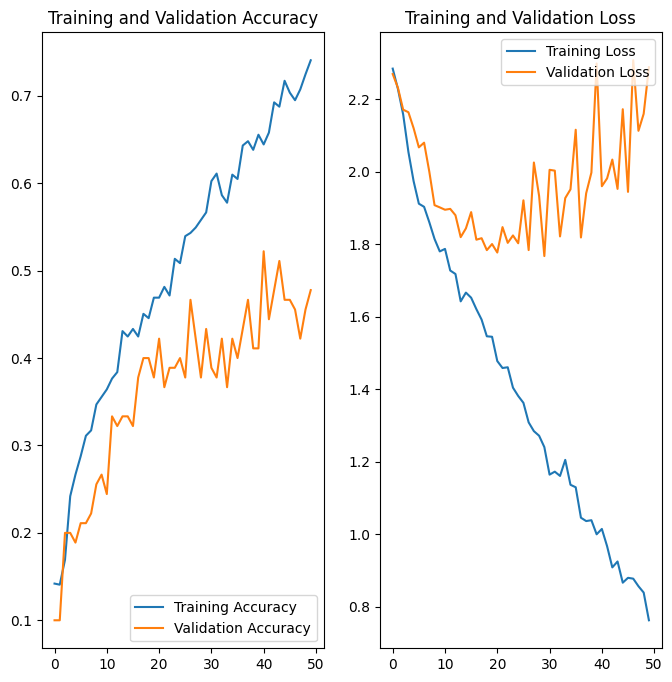

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's give VGG a try. We'll be using the keras applications for VGG16 and VGG19.

In [30]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np


In [31]:


train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                    # validation_split=0.15,
                                    #fill_mode = 'constant',
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing


In [32]:
BATCH_SIZE=16

train_data_dir = 'skind_training'
test_data_dir = 'skind_validation'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(32, 32),
                                               class_mode='categorical',
                                               
                                               
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

testgen = train_generator.flow_from_directory(test_data_dir,
                                               target_size=(32, 32),
                                               class_mode='categorical',
                                               
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)




Found 450 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [33]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [34]:
input_shape = (32, 32, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_test_steps = testgen.samples // BATCH_SIZE
n_epochs = 200

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)


In [35]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=testgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_test_steps,
                            
                            verbose=1)


Epoch 1/200
28/28 [==============================] - 5s 97ms/step - loss: 2.3725 - accuracy: 0.1682 - val_loss: 1.9007 - val_accuracy: 0.2708
Epoch 2/200
28/28 [==============================] - 1s 33ms/step - loss: 2.1442 - accuracy: 0.2235 - val_loss: 2.0296 - val_accuracy: 0.2500
Epoch 3/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0261 - accuracy: 0.2604 - val_loss: 1.8900 - val_accuracy: 0.3125
Epoch 4/200
28/28 [==============================] - 1s 33ms/step - loss: 1.9984 - accuracy: 0.2581 - val_loss: 1.8869 - val_accuracy: 0.3750
Epoch 5/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0879 - accuracy: 0.2535 - val_loss: 2.0191 - val_accuracy: 0.2500
Epoch 6/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0225 - accuracy: 0.2926 - val_loss: 1.7906 - val_accuracy: 0.3750
Epoch 7/200
28/28 [==============================] - 1s 32ms/step - loss: 1.9254 - accuracy: 0.3065 - val_loss: 1.7695 - val_accuracy: 0.3125
Epoch 

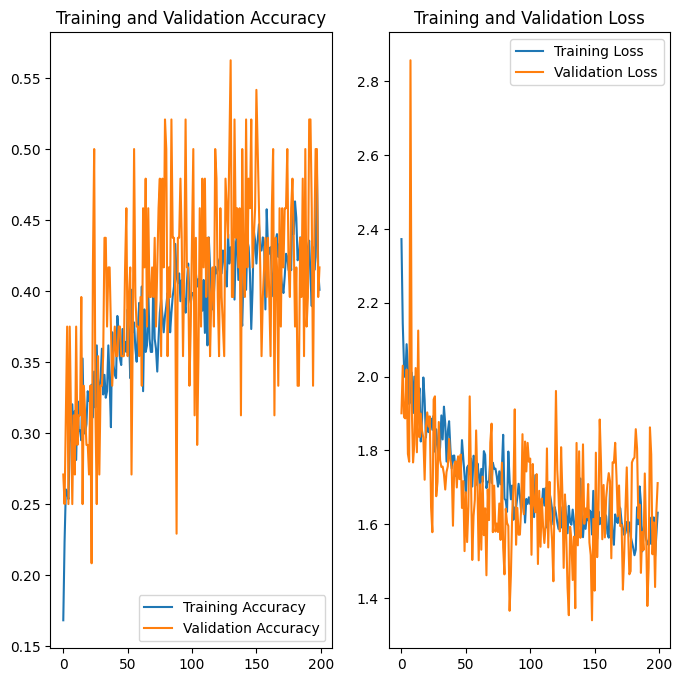

In [36]:
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']

loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

epochs_range = range(n_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let's give it a shot with InceptionV3

In [37]:


train_generator_in = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                    # validation_split=0.15,
                                    # fill_mode = 'constant',
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator_in = ImageDataGenerator( preprocessing_function=preprocess_input) # VGG16 preprocessing


In [38]:
BATCH_SIZE=16

train_data_dir = 'skind_training'
test_data_dir = 'skind_validation'

traingen_in = train_generator_in.flow_from_directory(train_data_dir,
                                               target_size=(32, 32),
                                               class_mode='categorical',
                                               
                                               
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

testgen_in = train_generator_in.flow_from_directory(test_data_dir,
                                               target_size=(32, 32),
                                               class_mode='categorical',
                                               
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)


Found 450 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [39]:
def create_model_in(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = InceptionV3(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer= optimizer, #RMSprop(lr=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [40]:
input_shape = (32, 32, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen_in.samples // BATCH_SIZE
n_test_steps = testgen_in.samples // BATCH_SIZE
n_epochs = 200


inc_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

In [41]:
inc_history = inc_model.fit(traingen_in,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=testgen_in,
                            steps_per_epoch=n_steps,
                            validation_steps=n_test_steps,
                            
                            verbose=1)

Epoch 1/200
28/28 [==============================] - 2s 38ms/step - loss: 2.4998 - accuracy: 0.1613 - val_loss: 2.0850 - val_accuracy: 0.2500
Epoch 2/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0691 - accuracy: 0.2488 - val_loss: 2.0157 - val_accuracy: 0.3125
Epoch 3/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0610 - accuracy: 0.2558 - val_loss: 1.9111 - val_accuracy: 0.3333
Epoch 4/200
28/28 [==============================] - 1s 32ms/step - loss: 1.9826 - accuracy: 0.2857 - val_loss: 1.9861 - val_accuracy: 0.3125
Epoch 5/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0277 - accuracy: 0.2765 - val_loss: 1.7831 - val_accuracy: 0.3333
Epoch 6/200
28/28 [==============================] - 1s 32ms/step - loss: 2.0244 - accuracy: 0.2765 - val_loss: 1.9238 - val_accuracy: 0.3333
Epoch 7/200
28/28 [==============================] - 1s 32ms/step - loss: 1.9347 - accuracy: 0.2857 - val_loss: 1.8028 - val_accuracy: 0.3125
Epoch 

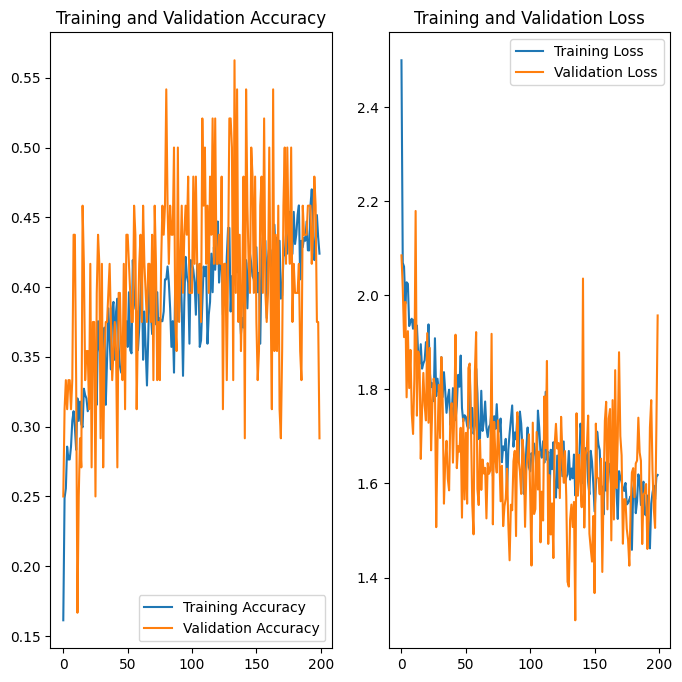

In [42]:
acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']

loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs_range = range(n_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notes: 

-batch size 8 only seems to help Alexnet with SGD (will change to Adam)

-unfreezing too many conv layers doesn't help much 

-should try Adam across the board, releasing few conv layers with no imagenet weights

-probably best to keep batch size 16 across the board also 

-small batch size seems to hurt VGG and Inception